In [15]:
import networkx as nx
import numpy as np
import pandas as pd

In [ ]:
file_path = 'soc-Epinions1.txt'

# Read the file while skipping header lines
with open(file_path, 'r') as f:
    edge_list = [
        line.strip().split() for line in f if not line.startswith('#')
    ]

print(len(edge_list))
print(edge_list[:10])

Number of edges:  10151
Number of nodes:  1000


In [ ]:
G = nx.DiGraph()
G.add_edges_from((int(u), int(v)) for u, v in edge_list)


print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

In [17]:
def random_strategy(G, num_pivots):
    """
    Select nodes uniformly at random.
    """
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)

In [18]:
# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [19]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [20]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots
pivots = pagerank_pivot_selection(G, 3)
pivots

[767, 123, 814]

In [21]:
def precompute_shortest_paths(G):
    """
    Precompute all-pairs shortest paths and store as a dictionary.
    """
    return dict(nx.all_pairs_shortest_path_length(G))

In [22]:
def euclidean_distance(exact, estimated):
    """
    Compute the Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    return np.linalg.norm(exact_values - estimated_values)

In [23]:
from itertools import combinations

def compute_inversion_distance(exact_scores, estimated_scores):
    # Rank the nodes based on scores (higher scores get lower ranks)
    exact_ranking = sorted(exact_scores.items(), key=lambda x: x[1], reverse=True)
    estimated_ranking = sorted(estimated_scores.items(), key=lambda x: x[1], reverse=True)

    # Create dictionaries to map nodes to their ranks
    exact_ranks = {node: rank for rank, (node, _) in enumerate(exact_ranking, 1)}
    estimated_ranks = {node: rank for rank, (node, _) in enumerate(estimated_ranking, 1)}

    # Count inversions
    inversion_count = 0
    for u, v in combinations(exact_scores.keys(), 2):  # Compare all pairs of nodes
        exact_order = exact_ranks[u] - exact_ranks[v]  # Positive if u ranks higher than v
        estimated_order = estimated_ranks[u] - estimated_ranks[v]  # Positive if u ranks higher than v
        
        if exact_order * estimated_order < 0:  # Orders are inverted
            inversion_count += 1

    return inversion_count


## closeness centrality

In [24]:
def estimate_closeness_centrality(G, pivots, shortest_paths):
    """
    Estimate closeness centrality using precomputed shortest paths.
    """
    closeness_estimates = {}
    for node in G.nodes:
        distances = [shortest_paths[pivot].get(node, float('inf')) for pivot in pivots]
        finite_distances = [d for d in distances if d != float('inf')]
        if finite_distances:
            avg_distance = sum(finite_distances) / len(finite_distances)
            closeness_estimates[node] = 1 / avg_distance if avg_distance > 0 else 0
        else:
            closeness_estimates[node] = 0
    return closeness_estimates


In [25]:
exact_closeness = nx.closeness_centrality(G)
# Precompute all-pairs shortest paths
shortest_paths = precompute_shortest_paths(G)
print('Exact closeness centrality: ', exact_closeness)

Exact closeness centrality:  {0: 0.30569155446756424, 1: 0.30494505494505497, 2: 0.30852378011117976, 3: 0.3168411037107517, 4: 0.29937069223853763, 5: 0.30337078651685395, 6: 0.3042021924482339, 7: 0.31306800376057664, 8: 0.3230918499353169, 9: 0.32019230769230766, 10: 0.3031866464339909, 11: 0.33322214809873246, 12: 0.32435064935064933, 13: 0.31228508909034075, 14: 0.33830003386386726, 15: 0.2859187178019462, 16: 0.296, 17: 0.30099427538415185, 18: 0.3217391304347826, 19: 0.3226744186046512, 20: 0.3076686171850939, 21: 0.28429140580535, 22: 0.3133626097867001, 23: 0.31664025356576864, 24: 0.3042948522692659, 25: 0.2872340425531915, 26: 0.2908296943231441, 27: 0.31228508909034075, 28: 0.309863523573201, 29: 0.3103448275862069, 30: 0.2928759894459103, 31: 0.2802244039270687, 32: 0.31073094867807155, 33: 0.3174451858913251, 34: 0.3146456692913386, 35: 0.31968, 36: 0.300090117152298, 37: 0.3013574660633484, 38: 0.32625734813847157, 39: 0.31228508909034075, 40: 0.2999099369558691, 41: 0.3

In [26]:
def run_strategy(G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_closeness):
    """
    Optimized strategy function using precomputed shortest paths.
    """
    results = []
    for num_pivots in num_pivots_list:
        pivots = pivot_strategy(G, num_pivots)
        estimated_closeness = estimate_closeness_centrality(G, pivots, shortest_paths)
        euclidean_dist = np.sqrt(
            sum((exact_closeness[node] - estimated_closeness.get(node, 0))**2 for node in G.nodes)
        )
        results.append({
            "run": run,
            "num_pivots": num_pivots,
            "strategy": pivot_strategy.__name__,
            "euclidean_distance": euclidean_dist,
            "estimated_closeness": estimated_closeness
        })
    return results

In [27]:
import concurrent.futures
from tqdm import tqdm

def run_experiment_closeness(G, pivot_strategy, runs=20):
    """
    Optimized experiment function with precomputed shortest paths.
    """
    exact_closeness = nx.closeness_centrality(G)
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]

    all_results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                run_strategy, G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_closeness
            )
            for run in range(runs)
        ]
        for future in tqdm(concurrent.futures.as_completed(futures), total=runs, desc="Experiment Progress"):
            all_results.extend(future.result())
    
    return pd.DataFrame(all_results)

In [28]:

results_random = run_experiment_closeness(G, random_strategy, runs=20)
results_pagerank = run_experiment_closeness(G, pagerank_pivot_selection, runs=20)
results_ran_indeg = run_experiment_closeness(G, ran_indeg_strategy, runs=20)
results_ran_outdeg = run_experiment_closeness(G, ran_outdeg_strategy, runs=20)

Experiment Progress: 100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


In [29]:
print(results_pagerank.head())

   run  num_pivots                  strategy  euclidean_distance  \
0    1          50  pagerank_pivot_selection            0.382622   
1    1         100  pagerank_pivot_selection            0.245414   
2    1         150  pagerank_pivot_selection            0.182578   
3    1         200  pagerank_pivot_selection            0.139952   
4    1         250  pagerank_pivot_selection            0.118307   

                                 estimated_closeness  
0  {0: 0.29069767441860467, 1: 0.3012048192771084...  
1  {0: 0.2976190476190476, 1: 0.29940119760479045...  
2  {0: 0.29940119760479045, 1: 0.3, 2: 0.30800821...  
3  {0: 0.29850746268656714, 1: 0.2994011976047904...  
4  {0: 0.29904306220095694, 1: 0.3019323671497584...  


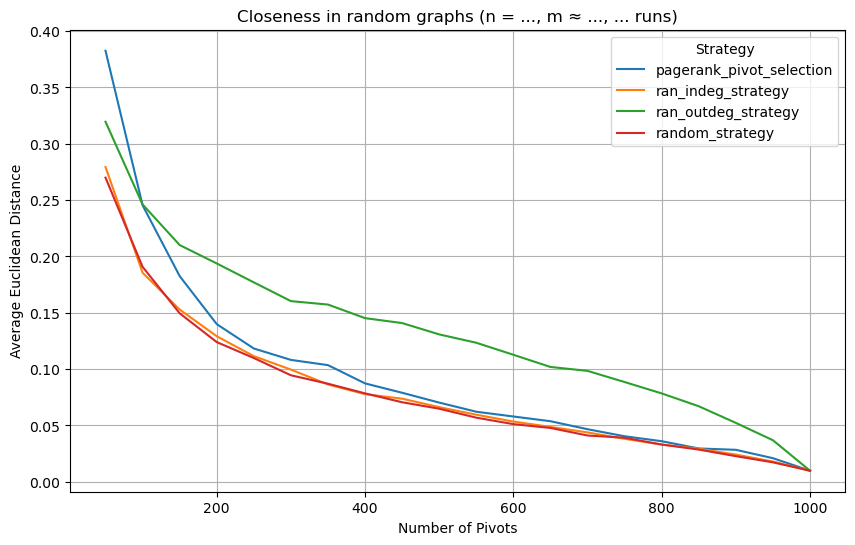

In [30]:
import matplotlib.pyplot as plt

all_results_closeness = pd.concat([results_random, results_pagerank, results_ran_indeg, results_ran_outdeg], ignore_index=True)

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped = all_results_closeness.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

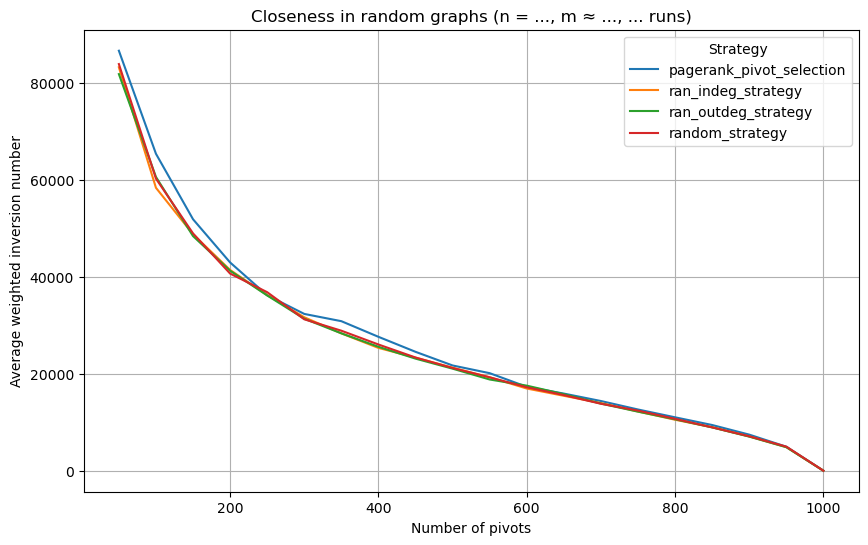

In [31]:
all_results_closeness["inversion_distance"] = all_results_closeness["estimated_closeness"].apply(
    lambda est_closeness: compute_inversion_distance(exact_closeness, est_closeness)
)
all_results_closeness["inversion_distance"].head()

# Group by `num_pivots` and `strategy` to compute the average inversion distance
avg_inversion = all_results_closeness.groupby(["num_pivots", "strategy"])["inversion_distance"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot each strategy
for strategy in avg_inversion["strategy"].unique():
    strategy_data = avg_inversion[avg_inversion["strategy"] == strategy]
    plt.plot(
        strategy_data["num_pivots"],
        strategy_data["inversion_distance"],
        label=strategy
    )

# Add labels, legend, and title
plt.xlabel("Number of pivots")
plt.ylabel("Average weighted inversion number")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

## betweenness centrality

In [32]:
def estimate_betweenness_centrality(G, pivots, shortest_paths):
    """
    Estimate betweenness centrality using precomputed shortest paths.
    """
    betweenness_estimates = {node: 0 for node in G.nodes}

    for pivot in pivots:
        # Get shortest paths from precomputed data
        pivot_paths = shortest_paths[pivot]
        dependency = {node: 0 for node in G.nodes}

        # Backtrack to calculate dependencies
        for target in pivot_paths:
            if target == pivot:
                continue  # Skip the pivot itself
            stack = [target]
            while stack:
                current = stack.pop()
                if current == pivot:
                    continue
                parents = [
                    neighbor
                    for neighbor in G.predecessors(current)
                    if pivot_paths.get(neighbor, float('inf')) + 1 == pivot_paths[current]
                ]
                num_parents = len(parents)
                if num_parents > 0:
                    for parent in parents:
                        dependency[parent] += (1 + dependency[current]) / num_parents
                        stack.append(parent)

        # Accumulate the dependencies into the betweenness estimates
        for node, count in dependency.items():
            if node != pivot:
                betweenness_estimates[node] += count

    # Normalize the betweenness estimates for directed graphs
    n = len(G.nodes)
    for node in betweenness_estimates:
        betweenness_estimates[node] /= (n - 1) * (n - 2)

    return betweenness_estimates


In [33]:
exact_betweenness = nx.betweenness_centrality(G)
print('Exact closeness centrality: ', exact_betweenness)

Exact closeness centrality:  {0: 0.0014655733430285055, 1: 0.0019174829494297988, 2: 0.0033430329463745878, 3: 0.0015579939321773639, 4: 0.002846494876882554, 5: 0.0023203751199351963, 6: 0.001718363426302686, 7: 0.0030652354414106428, 8: 0.002536989686593267, 9: 0.004296367112674456, 10: 0.003105924399574244, 11: 0.0016140260603734033, 12: 0.005005458753704354, 13: 0.0040737559412196145, 14: 0.0026051931865911887, 15: 0.001111955066191938, 16: 0.0014469417599352963, 17: 0.0007860524327170682, 18: 0.0011600363897938666, 19: 0.004498123427490027, 20: 0.002082954124520581, 21: 0.0015719614249102044, 22: 0.0025824474518371986, 23: 0.0020526561103529303, 24: 0.0011917933505916692, 25: 0.0019589024859749523, 26: 0.0013724805791162434, 27: 0.0029710151027376457, 28: 0.0017548560566160874, 29: 0.0031898273589983216, 30: 0.0009991360922399753, 31: 0.0010749859752443342, 32: 0.002301072628050064, 33: 0.0030377337710509166, 34: 0.0025740811450738546, 35: 0.0023423711099944556, 36: 0.001885113147

In [34]:

def run_strategy_betweenness(G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_betweenness):
    """
    Run a single strategy for betweenness estimation.
    """
    results = []
    for num_pivots in num_pivots_list:
        pivots = pivot_strategy(G, num_pivots)
        estimated_betweenness = estimate_betweenness_centrality(G, pivots, shortest_paths)
        euclidean_dist = np.sqrt(
            sum((exact_betweenness[node] - estimated_betweenness.get(node, 0))**2 for node in G.nodes)
        )
        results.append({
            "run": run,
            "num_pivots": num_pivots,
            "strategy": pivot_strategy.__name__,
            "euclidean_distance": euclidean_dist,
            "estimated_betweenness": estimated_betweenness
        })
    return results

In [35]:
def run_experiment_betweenness(G, pivot_strategy, runs=20):
    """
    Experiment to evaluate pivot-based betweenness centrality approximation.
    """
    
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    
    all_results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                run_strategy_betweenness, G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_betweenness
            )
            for run in range(runs)
        ]
        for future in tqdm(concurrent.futures.as_completed(futures), total=runs, desc="Betweenness Experiment Progress"):
            all_results.extend(future.result())
    
    return pd.DataFrame(all_results)  

In [36]:
from concurrent.futures import ProcessPoolExecutor

def run_experiment_betweenness(G, pivot_strategy, runs=20):
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]  # Fewer pivots
    all_results = []
    
    with ProcessPoolExecutor() as executor: 
        futures = [
            executor.submit(
                run_strategy_betweenness, G, pivot_strategy, num_pivots_list, run, shortest_paths, exact_betweenness
            )
            for run in range(runs)
        ]
        for future in tqdm(concurrent.futures.as_completed(futures), total=runs):
            all_results.extend(future.result())
    
    return pd.DataFrame(all_results)


In [ ]:

results_random = run_experiment_betweenness(G, random_strategy, runs=20)
results_pagerank = run_experiment_betweenness(G, pagerank_pivot_selection, runs=20)
results_ran_indeg = run_experiment_betweenness(G, ran_indeg_strategy, runs=20)
results_ran_outdeg = run_experiment_betweenness(G, ran_outdeg_strategy, runs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
strategies = [random_strategy, pagerank_pivot_selection, ran_indeg_strategy, ran_outdeg_strategy]

all_results_betweenness = pd.DataFrame()
for strategy in strategies:
    strategy_results = run_experiment_betweenness(G, strategy)
    all_results_betweenness = pd.concat([all_results_betweenness, strategy_results], ignore_index=True)


all_results_betweenness.head()

NameError: name 'run_strategy_betweenness' is not defined

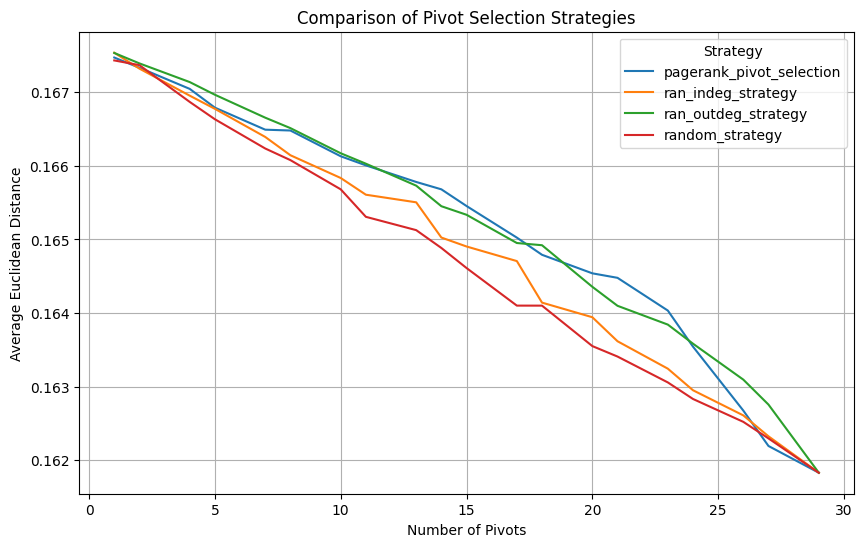

In [ ]:
import matplotlib.pyplot as plt

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped_betweenness = all_results_betweenness.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped_betweenness.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title(f"Betweenness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

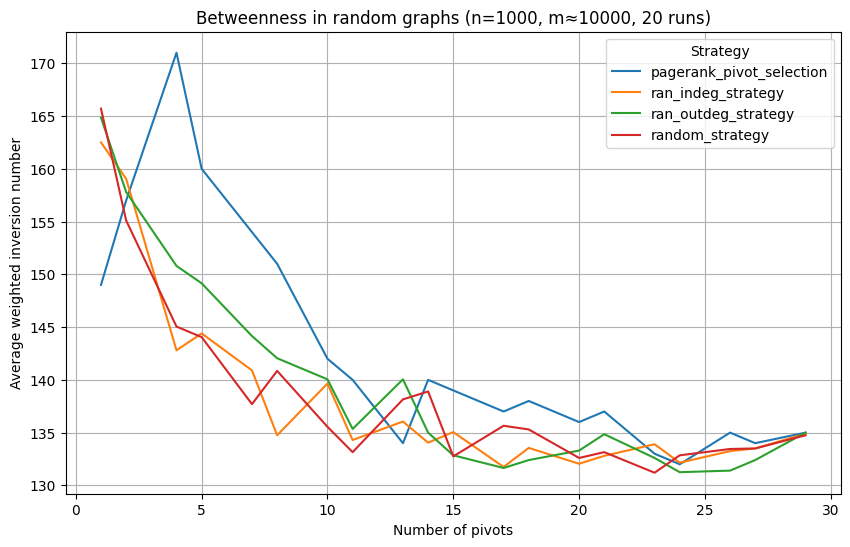

In [ ]:
all_results_betweenness["inversion_distance"] = all_results_betweenness["estimated_betweenness"].apply(
    lambda est_betweenness: compute_inversion_distance(exact_betweenness, est_betweenness)
)
all_results_betweenness["inversion_distance"].head()

# Group by `num_pivots` and `strategy` to compute the average inversion distance
avg_inversion = all_results_betweenness.groupby(["num_pivots", "strategy"])["inversion_distance"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot each strategy
for strategy in avg_inversion["strategy"].unique():
    strategy_data = avg_inversion[avg_inversion["strategy"] == strategy]
    plt.plot(
        strategy_data["num_pivots"],
        strategy_data["inversion_distance"],
        label=strategy
    )

# Add labels, legend, and title
plt.xlabel("Number of pivots")
plt.ylabel("Average weighted inversion number")
plt.title("Betweenness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()